In [1]:
# %pip install torch==2.2.2
# %pip install pandas==2.2.2
# %pip install numpy==1.26.4
# %pip install --upgrade jupyter ipywidgets
# %pip install nltk
# %pip install matplotlib
# %pip install seaborn==0.13.2
# %pip install peft
# %pip install Datasets==3.2.0
# %pip install transformers==4.47.0
# %pip install torch==2.5.1+cu121
# %pip install scikit-learn==1.2.2
# %pip install nltk==3.2.4

**1. Import necessary Libraries**

In [2]:
from datasets import Dataset, load_dataset
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import torch
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import re

**2. Data Preparation**

In [3]:
column_names = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']
df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",
                 header=None,
                 names=column_names)

In [4]:
label_values = set(df["sentiment"])
print("Unique sentiment values:", label_values)

Unique sentiment values: {'Negative', 'Positive', 'Neutral', 'Irrelevant'}


In [5]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

def preprocess_data(df):
    """
    Preprocess the input DataFrame by cleaning text data and removing unnecessary columns,
    as well as encoding the sentiment column into numeric labels.

    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'Tweet content', 'sentiment', 'Tweet ID', and 'entity'.

    Returns:
    pd.DataFrame: Preprocessed DataFrame with cleaned text and numeric sentiment labels.
    """
    # Remove rows with missing or empty 'Tweet content' and 'sentiment'
    df = df[(df['Tweet content'].notna()) & (df['Tweet content'] != '')]
    df = df[(df['sentiment'].notna()) & (df['sentiment'] != '')]

    # Drop unnecessary columns
    df = df.drop(['Tweet ID', 'entity'], axis=1)

    # Define a text cleaning function
    def clean_text(text):
        if isinstance(text, str):
            stop_words = set(stopwords.words('english'))
            tokens = text.lower().split()
            cleaned_text = ' '.join([word for word in tokens if word not in stop_words])
            return cleaned_text
        else:
            return text

    # Apply text cleaning to the 'Tweet content' column
    df['Text'] = df['Tweet content'].apply(clean_text)

    # Encode the sentiment column using LabelEncoder
    encoder = LabelEncoder()
    df['labels'] = encoder.fit_transform(df['sentiment'])

    # Create a label mapping for sentiment values
    label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    print("Label Mapping:", label_mapping)  # Print the label mapping for reference
    
    return df

In [6]:
def split_data(df, test_size, val_size, random_state):
    """
    Splits the dataset into training, validation, and test sets.
    
    Parameters:
    - df: The dataset to be split.
    - test_size: Proportion of the data to be used as the test set (default 0.2).
    - val_size: Proportion of the data to be used as the validation set (default 0.2).
    - random_state: Random seed for reproducibility (default None).
    
    Returns:
    - df_train: The training set.
    - df_val: The validation set.
    - df_test: The test set.
    """
    
    df_train, df_temp = train_test_split(df, test_size=test_size + val_size, random_state=random_state)
    df_val, df_test = train_test_split(df_temp, test_size=val_size / (val_size + test_size), random_state=random_state)
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    return df_train, df_val, df_test


In [7]:
preprocessed_df = preprocess_data(df)
df_train, df_val, df_test = split_data(preprocessed_df, test_size=0.1, val_size=0.1, random_state=1)

Label Mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


* Label 0: Indicates a Irrelevant sentiment. It means the tweet expresses a **Irrelevant** opinion or view.
* Label 1: Indicates a negative sentiment. It means the tweet expresses a **Negative** opinion or view.
* Label 2: Indicates a Neutral sentiment. It means the tweet expresses a **Neutral** opinion or view.
* Label 3: Indicates a positive sentiment. It means the tweet expresses a **positive** opinion or view.

In [8]:
df_train

,sentiment,Tweet content,Text,labels
0,Negative,@ DuvalMagic why tf can I only free Hebble but...,@ duvalmagic tf free hebble release him!? plz ...,1
1,Irrelevant,Girls playing pubg and turn their sound mic on...,girls playing pubg turn sound mic sexually sed...,0
2,Positive,@EpicGames This is one of your biggest Fortnit...,"@epicgames one biggest fortnite fans, love gam...",3
3,Positive,I've gotten back into my obsession with overwa...,i've gotten back obsession overwatch missed lo...,3
4,Neutral,Johnson & Johnson US Covid - 19 vaccine study ...,johnson & johnson us covid - 19 vaccine study ...,2
...,...,...,...,...
59191,Irrelevant,I'm as divided as I'm supposed to be these day...,"i'm divided i'm supposed days - find term ""gen...",0
59192,Negative,"@CSGO fix the stuttering issue, i have played ...","@csgo fix stuttering issue, played 1 match tod...",1
59193,Negative,10 Do that I even want Sam to know what window...,10 even want sam know windows update installed...,1
59194,Negative,Hello @ EAHelp I have had Madeleine McCann in ...,hello @ eahelp madeleine mccann basement last ...,1


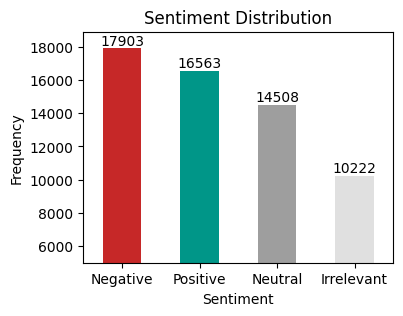

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sentiment_counts = df_train['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['#C62828', '#009688', '#9E9E9E', '#E0E0E0'])
for idx, value in enumerate(sentiment_counts):
    plt.text(idx, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.ylim(5000, max(sentiment_counts) + 1000)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

***Random Forest***

In [10]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import RandomForestClassifier
# X_train, y_train = df_train['Text'], df_train['labels'] 
# clf = Pipeline([
#     ('vectorizer_tri_grams', TfidfVectorizer()),
#     ('RandomForest', (RandomForestClassifier()))          
# ])
# clf.fit(X_train, y_train)

In [11]:
# X_val, y_val = df_val['Text'], df_val['labels'] 
# pred = clf.predict(X_val)
# print(accuracy_score(y_val, pred))

**3. Loading a pre-trained BERT Model**

In [12]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# change to Hugging Face Dataset
df_train_bert = Dataset.from_pandas(df_train[["Text","labels"]])
df_val_bert = Dataset.from_pandas(df_val[["Text","labels"]])
df_test_bert = Dataset.from_pandas(df_test[["Text","labels"]])

# load tokenizer
model_checkpoint = "/kaggle/input/automodelforsequenceclassification/pytorch/default/1/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_data(example):
    return tokenizer(example["Text"], padding="max_length", truncation=True)

tokenized_dataset_train = df_train_bert.map(preprocess_data, batched=True)
tokenized_dataset_val = df_val_bert.map(preprocess_data, batched=True)
tokenized_dataset_test = df_test_bert.map(preprocess_data, batched=True)

label2id = {0: "irrelevant", 1: "negative", 2: "neutral", 3: "positive"}
id2label = {v: k for k, v in label2id.items()}

model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=4,  
    id2label=label2id,
    label2id=id2label,
    ignore_mismatched_sizes=True
)

from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False,
    r=4,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]
)

model_lora = get_peft_model(model_bert, lora_config)
model_lora.print_trainable_parameters()

Map:   0%|          | 0/59196 [00:00<?, ? examples/s]

Map:   0%|          | 0/7400 [00:00<?, ? examples/s]

Map:   0%|          | 0/7400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/automodelforsequenceclassification/pytorch/default/1/distilbert-base-uncased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 667,396 || all params: 67,623,944 || trainable%: 0.9869


In [17]:
# device = training_args.device 
# model_bert_d = model_bert.to(device)


inputs = [
    "The movie was absolutely amazing, from the plot to the performances!",
    "I don’t understand why everyone loves this game, it’s so glitchy and unplayable, totally a waste of money.",
    "The restaurant was okay, nothing special but not bad either.",
    "Just finished my morning workout, feeling great!",
    "This new phone is amazing, the camera quality is perfect, and it runs so smoothly.",
    "Horrible customer service! They never respond to my emails, and I’m still waiting for a refund.",
    "The movie was alright, just average, neither great nor terrible.",
    "Does anyone else love the smell of fresh rain? It’s so calming!",
    "Great service at the hotel, staff was friendly and welcoming, definitely coming back.",
    "Tried the new burger at this restaurant, and it was undercooked and tasteless. Not coming back."
]
print("----------------------------")
print("Untrained model predictions:")
print("----------------------------")
from IPython.display import display, HTML
for i in inputs:
    encoded_input = tokenizer(i, return_tensors="pt", 
                              padding=True, truncation=True)
    logits_bert = model_bert(**encoded_input).logits
    predicted_label_bert = logits_bert.argmax(dim=-1).item()
    display(HTML(f"{i} - <span style='font-weight: bold;'>{label2id[predicted_label_bert]}</span>"))


----------------------------
Untrained model predictions:
----------------------------


In [18]:
from transformers import TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./distilbert-base-uncased_lora_results",
    eval_strategy="steps",
    eval_steps=500,
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="steps",
    load_best_model_at_end=True,
    fp16=True
)


trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_dataset_train,  
    eval_dataset=tokenized_dataset_val, 
    tokenizer=tokenizer
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-2ff77da85868>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,1.053900,1.013532
1000,0.942600,0.945101
1500,0.971300,0.895677
2000,0.826200,0.910690
2500,0.842800,0.847928
3000,0.884700,0.814989
3500,0.834100,0.765414
4000,0.722400,0.736578
4500,0.749200,0.708468
5000,0.747100,0.683302


TrainOutput(global_step=5550, training_loss=0.8476099177523776, metrics={'train_runtime': 4059.5515, 'train_samples_per_second': 43.746, 'train_steps_per_second': 1.367, 'total_flos': 2.388955756098355e+16, 'train_loss': 0.8476099177523776, 'epoch': 3.0})

In [ ]:
# metrics = trainer.evaluate()
# print(metrics)

In [20]:
device = training_args.device 
trained_model = trainer.model
model_lora_d = trained_model.to(device)
# model_path = "./model_lora.pt"
# torch.save(model_lora_d.state_dict(), model_path)

model_lora_d.save_pretrained("./model_lora")
tokenizer.save_pretrained("./model_lora")


inputs = [
   "The movie was absolutely amazing, from the plot to the performances!",
    "I don’t understand why everyone loves this game, it’s so glitchy and unplayable, totally a waste of money.",
    "The restaurant was okay, nothing special but not bad either.",
    "Just finished my morning workout, feeling great!",
    "This new phone is amazing, the camera quality is perfect, and it runs so smoothly.",
    "Horrible customer service! They never respond to my emails, and I’m still waiting for a refund.",
    "The movie was alright, just average, neither great nor terrible.",
    "Does anyone else love the smell of fresh rain? It’s so calming!",
    "Great service at the hotel, staff was friendly and welcoming, definitely coming back.",
    "Tried the new burger at this restaurant, and it was undercooked and tasteless. Not coming back."
]

print("--------------------------")
print("Trained model predictions:")
print("--------------------------")
for i in inputs:
    encoded_input = tokenizer(i, return_tensors="pt", 
                              padding=True, truncation=True).to(device)
    logits_lora = model_lora_d(**encoded_input).logits
    predicted_label_lora = logits_lora.argmax(dim=-1).item()
    display(HTML(f"{i} - <span style='font-weight: bold;'>{label2id[predicted_label_lora]}</span>"))

--------------------------
Trained model predictions:
--------------------------


In [ ]:
# print("Evaluating on validation data:")
# metrics_val = trainer.evaluate(eval_dataset=tokenized_dataset_val)
# print(metrics_val)

# # Evaluate on test data
# print("Evaluating on test data:")
# metrics_test = trainer.evaluate(eval_dataset=tokenized_dataset_test)
# print(metrics_test)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

y_true = tokenized_dataset_test['labels']
y_pred = []  

for i in range(len(tokenized_dataset_test)):
    text_input = tokenized_dataset_test[i]['Text']  # Get the original text from the dataframe
    encoded_input = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Make the prediction
    logits = model_lora_d(**encoded_input).logits
    predicted_label = logits.argmax(dim=-1).item()  # Get the predicted label
    y_pred.append(predicted_label)


# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted for multiclass
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7348648648648649
Precision: 0.7353514744527535
Recall: 0.7348648648648649
F1-Score: 0.7328167577995044
Confusion Matrix:
[[ 850  149  140  207]
 [  87 1772  106  216]
 [ 144  198 1135  291]
 [ 118  160  146 1681]]


In [22]:
# Get the first 15 samples from the test data
test_samples = tokenized_dataset_test[:15]['Text']

print("-----------------------------------------")
print("Predictions for the first 15 test samples:")
print("-----------------------------------------")

for i in test_samples:
    encoded_input = tokenizer(i, return_tensors="pt", 
                              padding=True, truncation=True).to(device)
    logits_lora = model_lora_d(**encoded_input).logits
    predicted_label_lora = logits_lora.argmax(dim=-1).item()
    display(HTML(f"{i} - <span style='font-weight: bold;'>{label2id[predicted_label_lora]}</span>"))

-----------------------------------------
Predictions for the first 15 test samples:
-----------------------------------------


In [ ]:
from IPython.display import FileLink

FileLink('/kaggle/working/model_lora.pt')